# Task 2: Odd to even

### Problem statement:
Design a quantum algorithm that, when given numbers of range [1,N), converts all of the odd numbers into even numbers, such that they stay in the same range (so they cannot be less than 1 nor greater or equal to N). The number of qubits you are going to use is k = ceil(log_2(N)).


#### Example:

B = odd_to_even (N = 31,list= [1,2,2,4,5,6,7,11,17,21,22,23] )
print(B)

One possible output is
“[2,2,2,4,4,6,8,10,18,20,22,22]”

Multiple solutions exist.

Note: The original task statement wasn't grammatically correct, so I updated it without changing the task. Also, "N = 2^k where k is the number of qubits you are going to use" is in contradiction with N = 31 given in the example, so I instead use k = ceil(log_2(N)).

In [28]:
import numpy as np 
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
import math
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UnitaryGate
from qiskit_aer.noise import NoiseModel, pauli_error
import random
from collections import Counter
import matplotlib.pylab as plt

To solve this task, I prepare all of the numbers in a given list into an equal superpostion, after which I perform an algorithm that simultaniously checks the parity of each number and converts odd numbers into even. 

### Prepare equal superposition

In this step, we encode the data (the list of numbers) into a quantum state. We follow the approach given in the chapter 4.1.2. of the book $\textit{Machine Learning with Quantum Computers}$ by Maria Schuld and Francesco Petruccione.


First convert our numbers into binary strings to create a binary dataset $\mathcal{D}$, such that each pattern $x^m \in \mathcal{D}$ is represented by a binary string of the form $x^m = (x^m_1, ..., x^m_k)$ with $x^m_i \in \{0, 1\}$ for $i = 1, ..., k$. The bitstring length $k$ corresponds to the number of qubits we are going to use. The superposition we want to prepare is:

$$
\ket{\mathcal{D}}  = \frac{1}{\sqrt{M}} \sum_{m=1}^{M} \ket{x^m}.
$$

We will use the following quantum system:
$$
\ket{l_1,..., l_k; a_1, a_2; s1, ..., s_k; e_1, ..., e_{M+2}}
$$

with four registers: a $\textit{loading register}$ of k qubits $\ket{l_1, ..., l_k}$, the $\textit{ancilla register}$ $\ket{a_1, a_2}$ with two qubits, the $k$-qubit $\textit{storage register}$ $\ket{s_1, ..., s_k}$ and the $\textit{extra register}$ $\ket{e_1, ..., e_{M+2}}$ with additional $M + 2$ ancilla qubits.


The extra register will be ignored because we only use it to facilitate some operations (we immediately dispose of the extra ancillas once we're done using them), in contrast to the additional register which has a central role in the algorithm. The use of extra register will be explicitly stated at the appropriate points. Therefore, we will denote our quantum system as:
$$
\ket{l_1,..., l_k; a_1, a_2; s1, ..., s_k}
$$


The qubit $a_2$ will be used as a flag. The term with $a_2=0$ is called the $\textit{memory branch}$, while the term flagged with $a_2=1$ is called the $\textit{processing branch}$. The desired superposition is grown step by step: the algorithm iteratively loads bitstrings into the loading register after which the state is broken in two pieces, one "smaller" and one "larger". The smaller term is made permanent by adding it to the memory branch, while the bigger term is used for further data loading.

The procedure is as follows:

To illustrate how an iteration works, we assume that m bitstrings have already been encoded via iterations $1, ..., m$ of the algorithm. The current state is then:
$$
\frac{1}{\sqrt{M}}\sum_{i=1}^m \ket{0, ..., 0; 00; x^i_1, ..., x^i_k} + \sqrt{\frac{M-m}{M}} \ket{0, ..., 0; 01; 0, ..., 0}
$$


Now we load the $(m+1)^{th}$ pattern into the loading register of both branches by simply flipping the qubits that correspond to non-zero bits of the bitstring $x^{m+1}$. Next, within the processing branch, we copy the pattern into the storage register. This is done using a CCNOT gate, also known as Toffoli gate, with one control on the qubit we wish to copy and the other on the qubit $a_2$ (to constrain ourselves only on the processing branch). This yields:
$$
\frac{1}{\sqrt{M}}\sum_{i=1}^m \ket{x^{m+1}_1, ..., x^{m+1}_k; 00; x^i_1, ..., x^i_k} + \sqrt{\frac{M-m}{M}} \ket{x^{m+1}_1, ..., x^{m+1}_k; 01; x^{m+1}_1, ..., x^{m+1}_k;}
$$

Next, we flip $a_1$ to $1$ in the processing branch using a CNOT gate controlled on the $a_2$. Now we need to perform the "breaking" into a "smaller" and "bigger" subbranch. For this, we apply the single-qubit unitary
$$
\begin{pmatrix}
\sqrt{\frac{\mu - 1}{\mu}} & \frac{1}{\sqrt{\mu}} \\
\frac{-1}{\sqrt{\mu}} & \sqrt{\frac{\mu - 1}{\mu}} 
\end{pmatrix}
$$

with $\mu = M-m$ to qubit $a_2$ but controlled by $a_1$ (confined to the processing branch). This leads to
$$
\frac{1}{\sqrt{M}}\sum_{i=1}^m \ket{x^{m+1}_1, ..., x^{m+1}_k; 00; x^i_1, ..., x^i_k}\\ + \frac{1}{\sqrt{M}} \ket{x^{m+1}_1, ..., x^{m+1}_k; 10; x^{m+1}_1, ..., x^{m+1}_k;}\\ + \sqrt{\frac{M-(m+1)}{M}} \ket{x^{m+1}_1, ..., x^{m+1}_k; 11; x^{m+1}_1, ..., x^{m+1}_k;}
$$

To add the smaller branch, marked by $\ket{a_1 a_2} = \ket{10}$, to the memory branch, we have to flip $a_1$ back to $1$. This is where we use the extra register of ancilla qubits. Each time we need to do this, we use a new ancilla qubit, therefore we are now using the $(m+1)^{th}$ ancilla to store the $(m+1)^{th}$ bitstring. We apply CNOT to this ancilla controlled by $a_1$, followed by CNOT controlled by $a_2$. The ancilla will be 1 only if exactly one out of $a_1$ and $a_2$ is equal to 1, which is only the case for the targeted subbranch. Now, we apply CNOT to $a_1$ controlled by the ancilla, and we achieve $\ket{a_1 a_2} = \ket{00}$ for the smaller subbranch, effectively adding it to the memory branch. 


The remaining bigger branch will be used as a processing branch in the next iteration. To prepare it for this, we need to change $\ket{a_1 a_2} $ from $\ket{11}$ to $\ket{01}$, and we need to empty its storage register. The first is done easily by applying CNOT to $a_1$ controlled by $a_2$. The removal from the storage is conducted the same way as the copying to it was done: applying Toffoli gate on the qubit we wish to reset with one control on the corresponding loading register qubit and the other control on $a_2$.

Finally, the loading register of both branches needs to be reset to the ground state by reversing the loading operations.


For complete understanding, we also explain the starting iteration of the algorithm. We start in the ground state:
$$
\ket{0, ..., 0; 0, 0; 0, ..., 0}
$$
We apply a NOT gate to the qubit $a_2$ in order to move to the processing branch. From now on, the procedure is exactly the same (using $m = 0$) except that we don't yet have anything in the memory branch.

In [29]:
def encode_numbers(N, k, numbers):
    '''
    Encode all of the numbers in an equal superposition. 
    N: the maximum allowed number
    k: the number of qubits used for encoding
    numbers: the list of numbers to be encoded
    '''
    # prepare the registers
    M = len(numbers)
    loading_register = QuantumRegister(k, 'Loading Register')
    ancilla_register = QuantumRegister(2, 'Ancilla Register')
    storage_register = QuantumRegister(k, 'Storage Register')
    additional_ancilla = QuantumRegister(M+2, 'Extra Ancilla')
    classical_register = ClassicalRegister(k, 'Classical Register')
    qc = QuantumCircuit(loading_register, ancilla_register, storage_register, additional_ancilla, classical_register)
    # define the indices for ancillas a1 and a2, the first storage qubit s1, and the first extra ancilla e1
    a1 = k
    a2 = k + 1
    s1 = k + 2
    e1 = 2*k + 2
    for n, number in enumerate(numbers):
        if n == 0:
            # the first iteration - move completely into the processing branch
            qc.x(a2)
        # write the (binary) number into the loading register of both branches
        # make sure that every binary number is encoded with k digits (add zeros in front if it has less digits)
        for i, digit in enumerate(f"{number:0{k}b}"): 
            if int(digit) == 1:
                qc.x(i)
        # in the processing branch, copy the number into the storage register
        for i in range(k):
            qc.ccx(i, a2, s1+i)
        # flip a1 if a2=1
        qc.cx(a2,k)
        qc.barrier()
        # apply a unitary on a2 controlled by a1: split the processing branch into two subbranches, one that 
        # can be “added” to the memory branch and one that will remain the processing branch for the next step
        mu = M - n
        cU = Operator([
            [1,         0,              0,                              0],
            [0,         1,              0,                              0],
            [0,         0,      np.sqrt(1 - 1/mu),          np.sqrt(1/mu)],
            [0,         0,      -np.sqrt(1/mu),         np.sqrt(1 - 1/mu)]
        ])
        qc.unitary(cU, [a2, a1], label="cU") # had to swap the order of the a1 and a2 to get the correct control/target qubits
        qc.barrier()
        # change |a1a2> = |10> to |00> so it can be added to the memory branch, making use of an extra ancilla qubit
        qc.cx(a1, e1+n)
        qc.cx(a2, e1+n)
        qc.cx(e1+n, a1)
        # change |a1a2> = |11> to |01>
        qc.cx(a2, a1)
        qc.barrier()
        # reset the storage register of the processing branch and the loading register of both branches
        for i, digit in enumerate(f"{number:0{k}b}"):
            if int(digit) == 1:
                qc.cx(a2, s1+i)
                qc.x(i)
        qc.barrier()
    return qc

        
        

### Odd to even algorithm

First we check simultaneously the parity of each number in the superposition. For all numbers in the storage register, we look at their rightmost digit which determines the parity (this corresponds to the $(2k+1)^{th}$ qubit in our quantum circuit). If it's equal to 1, the number is odd, and we set a new ancilla qubit in the extra register to 1 using a CNOT gate. Next, we swap the control and target qubits of the previously used CNOT gate: if the number was determined to be odd, now the rightmost digit is changed to 0 and the number is even. Effectively, we just subtracted 1 from each odd number. In the problem statement, the numbers after the conversion were required to stay in the range [1,N). We see that this is not achieved for the number 1, which is converted to 0. This is why the number 1 is converted to the biggest allowed even number instead (so that we loop around).

In [30]:
def convert_to_even(N, qc, k, M):
    ''' 
    Convert simultaneously all odd numbers to even.
    N: the maximum allowed number
    qc: the quantum circuit to be measured
    k: the number of encoding qubits
    M: the length of the numbers list
    '''
    s1 = k + 2
    e1 = 2*k + 2
    qc.cx(s1 + (k-1), e1 + M)
    # convert odd numbers to even
    qc.cx(e1 + M, s1 + (k-1))
    qc.barrier()
    # check if any of the numbers are now equal to zero
    for i in range(k):
        qc.x(s1+i)
    qc.barrier()
    qc.mcx([(s1+x) for x in range(k)], e1 + M + 1)
    # if a number was equal to 0, convert it to biggest allowed even number
    max_even = N - 1 - (N - 1) % 2
    for i, digit in enumerate(f"{max_even:0{k}b}"):
        if int(digit) == 1:
            qc.cx(e1 + M + 1, s1+i)
    qc.barrier()
    for i in range(k):
        qc.x(s1+i)
    qc.barrier()
    return qc

### Measurement and running the circuit
Now we measure the whole storage register and store the result in the classical register. Then we run the circuit on the Aer simulator, using the number of shots equal to 100 per each number in the initial list. This makes it much easier to post-process the counts and infer what numbers we measured.

In [31]:
def measure_circuit(qc, k):
    '''
    Measure the storage register.
    qc: the quantum circuit to be measured
    k: the number of encoding qubits
    '''
    s1 = k + 2
    for i in range(k):
        qc.measure(s1+i,i)
    return qc

In [32]:
def run_simulation(qc, length):
    '''
    Run the simulation so that the shot number is equal to 100 x the number of numbers.
    qc: the quantum circuit to run the measurement simulation on
    length: the legnth of the numbers list
    '''
    # the counts aggregate over every entry, but don't discriminate which number came from which input.
    # this is where it stops being possible to match the even numbers with the input
    sim = Aer.get_backend('aer_simulator')
    result = sim.run(qc, shots=100*length).result()
    counts  = result.get_counts(qc)
    return counts

Here is an example circuit:

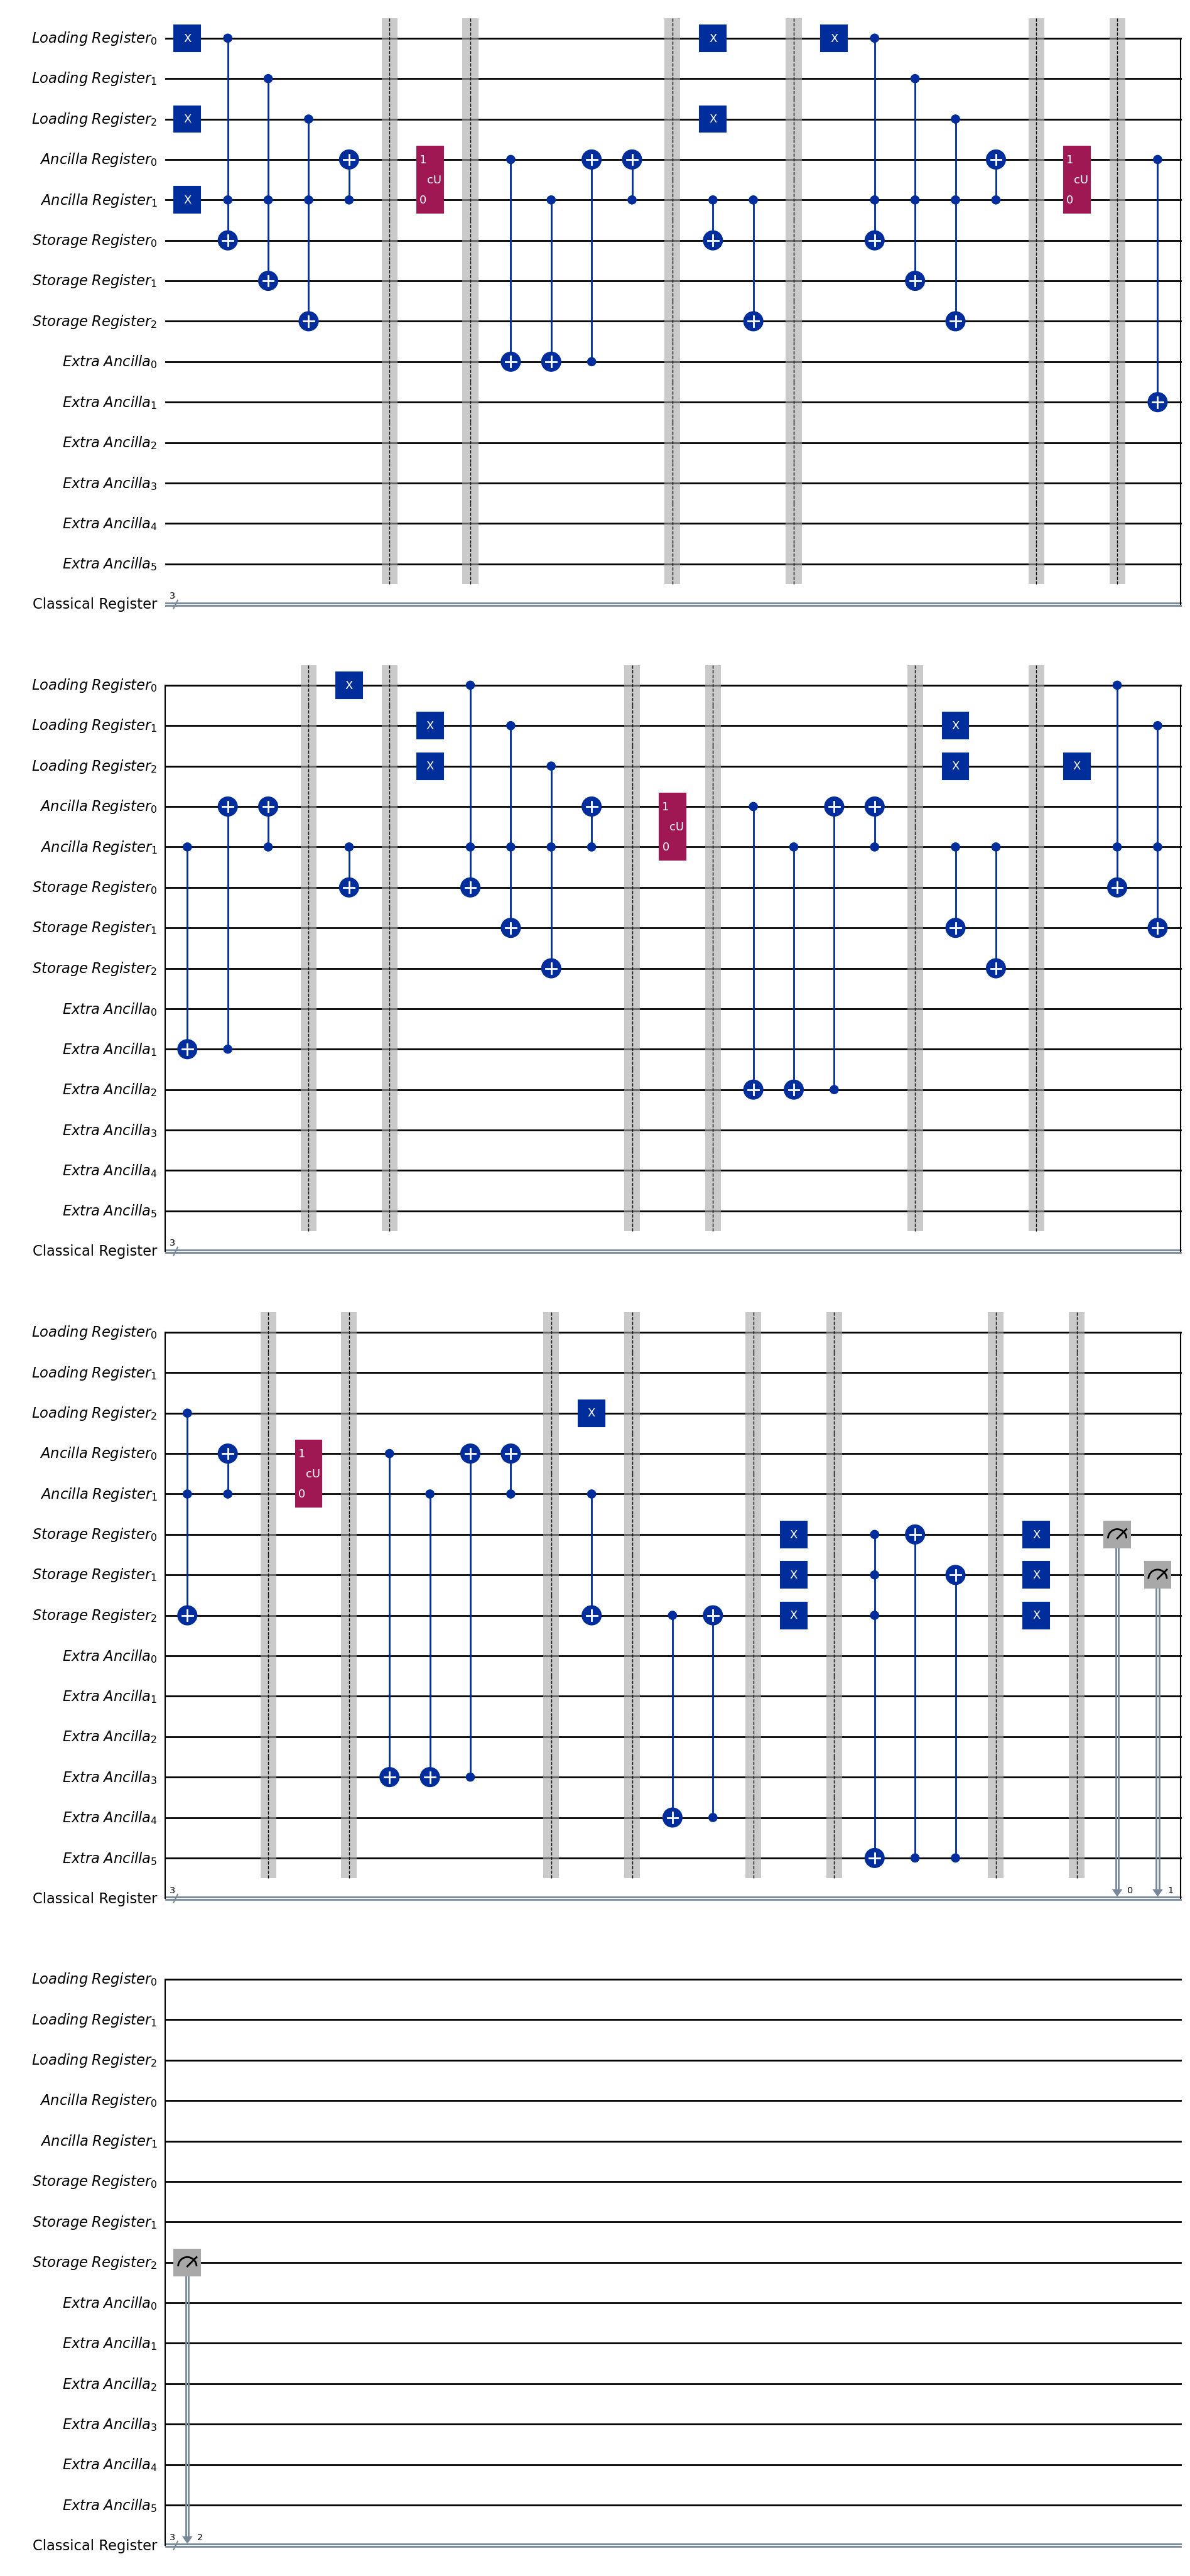

In [33]:
# these will be connected into one function later to avoid user mistakes, however we do this here in order to be able to draw the circuit
N = 7
numbers = [5, 4, 3, 1]
k = math.ceil(math.log2(N))
M = len(numbers)
qc = encode_numbers(N, k, numbers)
qc = convert_to_even(N, qc, k, M)
qc = measure_circuit(qc, k)
qc.draw('mpl')

The following figure shows the corresponding histogram of the measured counts (note that the binary numbers in the histogram should be read from right to left):

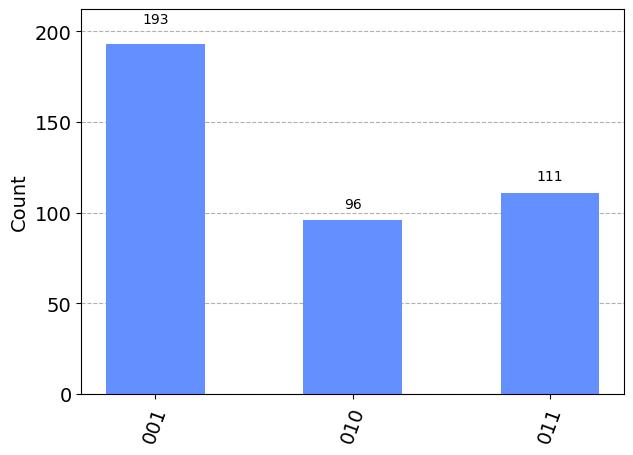

In [34]:
counts = run_simulation(qc, M)
plot_histogram(counts)

Finally, we need to create our list of even numbers from the counts.

In [35]:
def counts_to_dict(counts):
    '''
    Convert the counts to a dictionary.
    '''
    dict_counts = dict()
    for i in counts:
        # reverse the binary string from the counts and convert it to an int in base 2
        # divide by 100 to see how many instances of each (even) number we got
        dict_counts[int(i[::-1],2)] = round(counts[i]/100)
    return(dict_counts)

In [36]:
def dict_to_list(dict_counts):
    '''
    Convert the dictionary of counts to a list.
    '''
    even_numbers = []
    for key in dict_counts:
        even_numbers = even_numbers + [key]*dict_counts[key]
    return even_numbers


We combine everything in the function odd_to_even()

In [37]:
def odd_to_even(N, numbers):
    '''
    Convert every odd number from the list into an even number.
    N: the maximum number allowed in the list
    number: the list of numbers
    '''
    # don't allow numbers bigger than N
    if not max(numbers) < N:
        print("There is a number in the list that is bigger than allowed.")
        return 
    k = math.ceil(math.log2(N))
    M = len(numbers)
    qc = encode_numbers(N, k, numbers)
    qc = convert_to_even(N, qc, k, M)
    qc = measure_circuit(qc, k)
    counts = run_simulation(qc, M)
    dict_counts = counts_to_dict(counts)
    even_numbers = dict_to_list(dict_counts)
    print(even_numbers)

### Examples

Note that the output can't be matched with the input. However, the matching is still maintained before the measurement, we can easily track our numbers and perform any further manipulations we desire before we decide to measure. The specific requierements of the task are still fulfilled.

In [38]:
odd_to_even(10, [2, 5, 7, 7, 8, 9])

[2, 6, 6, 4, 8, 8]


In [39]:
odd_to_even (31, [1,2,2,4,5,6,7,11,17,21,22,23] )

[4, 4, 20, 10, 16, 30, 6, 6, 2, 2, 22, 22]


In [40]:
# this is not allowed because there is a number that's bigger than allowed
odd_to_even(15, [5, 7, 17, 4, 9])

There is a number in the list that is bigger than allowed.


### Extension of the task: including the noise


Today's quantum computers suffer from significant noise, and we need to explore how our algorithm would perform if we wanted it to be useful. For this reason, we prepare noise models which we feed to the Aer simulator.

In [41]:
# example error probabilities
p_meas = 0.01
p_gate1 = 0.01

# quantumError objects
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)]) # measurement error
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)]) # single-qubit gate error
error_gate2 = error_gate1.tensor(error_gate1) # two-qubit gate error
error_gate3 = error_gate2.tensor(error_gate1) # three-qubit gate error

# add errors to the noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate3, ["ccx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['ccx', 'cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'cx', 'u1', 'measure', 'ccx', 'u2']
  All-qubits errors: ['measure', 'u1', 'u2', 'u3', 'cx', 'ccx']


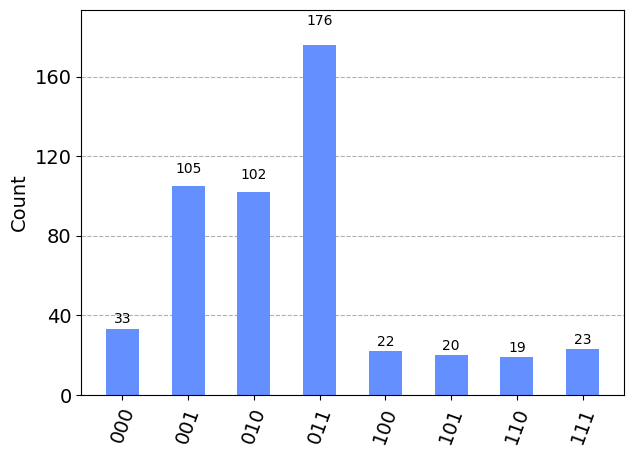

In [42]:
# prepare the quantum circuit
N = 8
numbers = [4, 1, 5, 7, 3]
k = math.ceil(math.log2(N))
M = len(numbers)
circ = encode_numbers(N, k, numbers)
circ = convert_to_even(N, circ, k, M)
circ = measure_circuit(circ, k)

# create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_bit_flip)

# transpile circuit for noisy basis gates
circ_tnoise = transpile(circ, sim_noise)

# run and get counts
# 100 shots per number because it makes it easier to read the relevant results from the output
result_noise = sim_noise.run(circ_tnoise, shots=100*M).result() 
counts_noise = result_noise.get_counts(0)

# plot noisy histogram
plot_histogram(counts_noise)

In the above histogram, we notice that now we have many more outputs, and sometimes we end up mistakenly with odd numbers. We need to find a way to quantify the accuracy of our algorithm. First we divide all results by 100 and round them (choosing the number of shots to be 100 times the length of the numbers list allows us to do this), and add them to a dictionary using counts_to_dict(). For example, if '010' (number 2) had 173 counts, it would be saved in the dictionary as {2: 2}. If '111' had 21 counts, it would be saved in the dictionary as {7: 0}. Next, we classicaly convert odd numbers to even so that we can use this to compare with our noisy results. 

In [43]:
def get_accuracy(numbers_dict, measured_dict):
    '''
    Get the accuracy of our noisy algorithm.
    numbers_dict: the dictionary with the correct even numbers
    measured_dict: the dictionary with the numbers from the noisy output
    '''
    total = 0
    correct = 0
    for key in numbers_dict:
        total = total + numbers_dict[key]
        if key in measured_dict:
            correct = correct + measured_dict[key]
    return correct/total

In [44]:
def classical_odd_to_even(N, numbers):
    ''' 
    Convert clasically all odd numbers to even.
    '''
    even_numbers = []
    for num in numbers:
        if num % 2:
            num = num - 1
            # [if num == 0]
            if not num:
                num = N - 1 - (N - 1) % 2
        even_numbers.append(num)
    return even_numbers

We would expect that the accuracy falls down as the length of the input list of numbers increases because we use more gates. Increasing the maximum allowed number in the list can increase the number of gates needed to encode the numbers, but we don't expect as strong fall in accuracy as in the previous case. To test these claims, we take different values for maximum allowed number and for the lengths of the numbers list: then we generate random numbers for the numbers lists. We run the noisy simulation and compute the accuracy. Due to the random generation of the numbers list, this should be repeated a few times and avereged for each parameter values.

In [45]:
def plot_accuracy(N, list_lengths, noise_model):
    '''  
    Find the accuracy of the noisy output.
    N: the maximum number allowed in the numbers list
    list_lengths: a list containig all the lengths of the numbers list we wish to plot
    noise_model: the noise model we prepare to account for the errors on the real hardware
    '''
    accuracies = []
    for lenth in list_lengths:
        temp_accuracies = []
        for i in range(5):
            numbers = []
            for i in range(lenth):
                numbers.append(random.randint(1,N))
            even_numbers = classical_odd_to_even(N, numbers)
            even_numbers_dict = dict(Counter(even_numbers))
            k = math.ceil(math.log2(N))
            M = lenth
            qc = encode_numbers(N, k, numbers)
            qc = convert_to_even(N, qc, k, M)
            qc = measure_circuit(qc, k)


            # Create noisy simulator backend
            sim_noise = AerSimulator(noise_model=noise_model)

            # Transpile circuit for noisy basis gates
            qc_noise = transpile(qc, sim_noise)

            # Run and get counts
            result_noise = sim_noise.run(qc_noise, shots=100*M).result()
            counts = result_noise.get_counts(0)
            measured_dict = counts_to_dict(counts)
            temp_accuracies.append(get_accuracy(even_numbers_dict, measured_dict))
        accuracies.append(np.mean(temp_accuracies))
    return accuracies


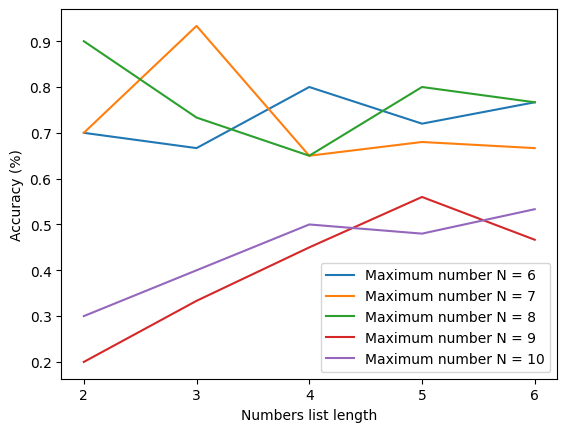

In [46]:
# this takes around 5 min to run
list_lengths = [2,3,4,5,6]
accuracies6 = plot_accuracy(6, list_lengths, noise_bit_flip)
plt.plot(list_lengths, accuracies6, label ="Maximum number N = 6")
accuracies7 = plot_accuracy(7, list_lengths, noise_bit_flip)
plt.plot(list_lengths, accuracies7, label ="Maximum number N = 7")
accuracies8 = plot_accuracy(8, list_lengths, noise_bit_flip)
plt.plot(list_lengths, accuracies8, label ="Maximum number N = 8")
accuracies9 = plot_accuracy(9, list_lengths, noise_bit_flip)
plt.plot(list_lengths, accuracies9, label ="Maximum number N = 9")
accuracies10 = plot_accuracy(10, list_lengths, noise_bit_flip)
plt.plot(list_lengths, accuracies10, label ="Maximum number N = 10")
plt.xticks(list_lengths)
plt.xlabel('Numbers list length')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

We notice that the expected falling trend of accuracy versus the list length is in fact not observed, as for some values of N the accuracy actually improves with increasing length. This is because the more numbers we randomly generate, the more chance we have of accidentally reaching the desired even numbers. We further notice that the overall accuracy is decreasing for bigger maximum numbers N. This is in agreement with our previous explanation - the "pool" of allowed even numbers is specified by N (it is 2, 4, ..., N - 1 - (N - 1) % 2), the bigger the pool is, the harder it is to accidentally reach the correct even number.

These results also indicate that our way of quantifying accuracy is not particularly good. It is not giving us any insight into whether a specific odd number was converted into the expected even number (by subtracting 1 from it). If we want to continue doing operations on our numbers, we would want to have a good idea of which numbers we currently possess and to which input number they correspond to.